<!-- <img align="left" style="padding-right:30px;" src="./Images/logo_UNSW.svg" height="100"><img align="left" style="padding-right:30px;" src="./Images/Green_RGB.png" height="90"><img align="left" style="padding-right:30px;" src="./Images/image004.png" height="100">
 -->

[![DOI](https://zenodo.org/badge/940091341.svg)](https://doi.org/10.5281/zenodo.14939868) <a href="https://www.globh2e.org.au/"><img src="https://img.shields.io/badge/ARC:Funding%20number-IC200100023-blue.svg"/></a>

# **<div style="text-align: left; font-size: 30px;"> Pathways to global hydrogen production within planetary boundaries**</div>
**<div style="text-align: left; font-size: 25px;"> Life cycle optimisation - Tutorial**</div>

<div style="text-align: left; font-size: 16px;">Michaël Lejeune<sup>a,b</sup>, Sami Kara<sup>a,b</sup>, Michael Zwicky Hauschild<sup>c,d</sup>, Sareh Sharabifarahni<sup>a</sup>, Rahman Daiyan<sup>b,e</sup></div><br>

<div style="text-align: left; font-size: 13px;"><sup>a</sup>Sustainability in Manufacturing and Life Cycle Engineering Research Group, School of Mechanical and Manufacturing Engineering, the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>b</sup>Australian Research Council Training Centre for the Global Hydrogen Economy (GlobH2e), the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>c</sup>Centre for Absolute Sustainability, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>d</sup>Section for Quantitative Sustainability Assessment (QSA), Department of Environmental and Resource Engineering, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>e</sup>School of Minerals and Energy Engineering, The University of New South Wales, Sydney 2052, Australia</div><br>


# **Target audience & prerequisites**

> <span style="color:rgba(22, 210, 69, 1); font-weight: bold;">Target audience</span><br>
>- Life cycle assessment practioners/researchers
>- Absolute environmental sustainability practioners/researchers

> <span style="color:rgba(191, 200, 30, 1); font-weight: bold;">Prerequisites</span><br>
>- Background in life cycle assessment
>- Brightway
>- Activity browser (with ScenarioLink installed)
>- Julia with JuMP.jl
>- CPLEX optimisation solver
>- IDE (e.g., VS code)

# **Intro to AESA**

<div style="text-align:center;">
  <img src="./Images/framwork2.svg">
</div>

<!-- # Contents <span style="color:rgba(0, 0, 0, 1); font-weight: bold;">Contents</span><br> -->
# **Contents**

>1. Background information on computational LCA and optimisation
>2. Installation of planetary boundaries characterisation factors
>3. Modelling aggregated inventories on Activity - browser
>4. pre-optimisation formating on Excel
>5. Implementation of the optimisation model in Julia using JuMP.jl


# **Case study**

<!-- > <span style="color:rgba(184, 193, 29, 1); font-weight: bold;">Simple optimisation example</span><br>
>- Optimisation of electrical mix for hydrogen production via PEM electrolysis
>- Using activity browser, excel and Julia (a python version is also possible)
>- Integration of prospective LCA data in the optimisation.
>- Optional - Cost and material tracking -->


> <span style="color:rgba(26, 190, 67, 1); font-weight: bold;">Goal  & Scope definition</span><br>
>- Goal: Minimising the effective planetary footprint of hydrogen production via PEM electrolysis.
>- LCA type: prospective attributional LCA (note that the appraoch can also be interpreted as consequential)
>- Functional unit: 225 MtH₂/year (2050) (global annual production of H₂ via water electrolysis)
>- Scope: Cradle to gate (electricity production + PEM electrolysis)
>- Database: ecoinvent 3.9.1 (cut-off) - updated with premise - SSP1-PkBudg500
<div style="text-align:center;">
  <img src="./Images//PEM_unit1.svg">
</div>


### **Initialisation**

In [550]:
using JuMP, CPLEX,Distributions,DataFrames,LinearAlgebra,XLSX
using PyPlot
using SparseArrays
using JLD2
PyPlot.svg(true)
using lce
initProject("Natcoms")
⊘ = ./;



┌ Info: Project Natcoms -> model:ecoinvent_3.9.1 RCP:0.0 SSP:0 year:0 loaded
└ @ lce /Users/mickael/Library/CloudStorage/OneDrive-UNSW/Research/Publications/Journal articles/1_Natcoms/code/lce/src/lce.jl:781


# **Data import**

In [10]:
aSOS = XLSX.readtable("./data/Fig2c.xlsx", "allocated SOS") |> DataFrame # %SOS/GtH2/yr



6×6 DataFrame
 Row │ Year    SOS_per_GtH2_05  SOS_per_GtH2_25  SOS_per_GtH2_50  SOS_per_GtH2 ⋯
     │ Any     Any              Any              Any              Any          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2025.0  6.73849          8.91468          9.53045          13.0886      ⋯
   2 │ 2030.0  4.29387          5.98068          7.23146          9.79054
   3 │ 2035.0  2.40314          3.25648          4.07245          7.64923
   4 │ 2040.0  1.50013          1.98989          2.65428          4.63441
   5 │ 2045.0  1.07436          1.51761          2.13706          2.69473      ⋯
   6 │ 2050.0  0.761957         1.18881          1.59743          2.49928
                                                               2 columns omitted

In [11]:
𝚪ᵦ=XLSX.readtable("./data/interactions_matrices.xlsx", "𝚪ᵦ") |> DataFrame



10×10 DataFrame
 Row │ Climate  change  Energy  imbalance  Climate  change  CO2  Concentration ⋯
     │ Any                                 Any                                 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1.22241                             0                                   ⋯
   2 │ 0                                   1.22241
   3 │ 0.325108                            0
   4 │ -0.684548                           0
   5 │ 0.220814                            0                                   ⋯
   6 │ 0.206199                            0
   7 │ 0.206199                            0
   8 │ -0.134465                           0
   9 │ 0.428032                            0                                   ⋯
  10 │ 0.718619                            0
                                                               8 columns omitted

In [12]:
𝚪=Matrix{Float64}(𝚪ᵦ)


10×10 Matrix{Float64}:
  1.22241   0.0      -0.0100732   …  -0.0710218    0.122241    0.38386
  0.0       1.22241  -0.0100732      -0.0710218    0.122241    0.38386
  0.325108  0.0       1.06115        -0.0188888    0.0325108   0.4567
 -0.684548  0.0       0.00564097      0.0397722   -0.0684548  -0.214962
  0.220814  0.0       0.0407336      -0.0128293    0.0220814   0.416858
  0.206199  0.0       0.0138327   …  -0.00198018   0.0206199   0.426595
  0.206199  0.0       0.0138327      -0.00198018   0.0206199   0.426595
 -0.134465  0.0       0.00110805      1.00781     -0.0134465  -0.0422246
  0.428032  0.0       0.233494       -0.0248687    1.0428      0.470084
  0.718619  0.0       0.185568       -0.0417518    0.0718619   1.28949

In [13]:
SOS = XLSX.readtable("./data/SOS.xlsx", "Planetary boundaries") |> DataFrame


10×7 DataFrame
 Row │ Control variable                   Pre-industrial value  Planetary boun ⋯
     │ Any                                Any                   Any            ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Climate change-Energy imbalance    0.0                   1.0            ⋯
   2 │ Climate change-CO2 Concentration   278.0                 350.0
   3 │ Ocean acidification-Carbonate io…  3.44                  2.752
   4 │ Atmospheric aerosol loading-Aero…  0.03                  0.1
   5 │ Freshwater use-Global              0.0                   4000.0         ⋯
   6 │ Biogeochemical flows-P             0.0                   11.0
   7 │ Biogeochemical flows-N             0.0                   62.0
   8 │ Stratospheric ozone depletion-St…  290.0                 276.0
   9 │ Land-system change-Global          100.0                 75.0           ⋯
  10 │ Biosphere Integrity-Change in bi…  100.0                 90.0
                                                               5 columns omitted

Safe operaring space 

In [14]:
categories=SOS[:,1]


10-element Vector{Any}:
 "Climate change-Energy imbalance"
 "Climate change-CO2 Concentration"
 "Ocean acidification-Carbonate ion concentration"
 "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)"
 "Freshwater use-Global"
 "Biogeochemical flows-P"
 "Biogeochemical flows-N"
 "Stratospheric ozone depletion-Stratospheric O3 concentration"
 "Land-system change-Global"
 "Biosphere Integrity-Change in biosphere integrity"

In [15]:
Δ𝐗ᴾᴮ=SOS[:,4]


10-element Vector{Any}:
    1.0
   72.0
    0.6880000000000002
    0.07
 4000.0
   11.0
   62.0
   14.0
   25.0
   10.0

In [16]:
units=SOS[:,end]


10-element Vector{Any}:
 "W/m2"
 "ppm"
 "Ωarag"
 "Aerosol optical depth"
 "km3"
 "TgP"
 "TgN"
 "Dobson units"
 "%"
 "%"

# **Allocation factor**

We want to express it in an allocation factor per kg of H2 produced.

In [17]:
α=aSOS[1,4] #%SOS/GtH2 (median value)
ω°=α/100*Δ𝐗ᴾᴮ# allocation factor per GtH2
𝛚 = ω° * 1e-12 # allocation factor per kgH2/yr

[a=>b=>c for (a,b,c) ∈ zip(categories,𝛚,units)]


10-element Vector{Pair{String, Pair{Float64, String}}}:
                              "Climate change-Energy imbalance" => (9.530448489833156e-14 => "W/m2")
                             "Climate change-CO2 Concentration" => (6.861922912679872e-12 => "ppm")
              "Ocean acidification-Carbonate ion concentration" => (6.556948561005213e-14 => "Ωarag")
      "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)" => (6.671313942883209e-15 => "Aerosol optical depth")
                                        "Freshwater use-Global" => (3.812179395933262e-10 => "km3")
                                       "Biogeochemical flows-P" => (1.0483493338816471e-12 => "TgP")
                                       "Biogeochemical flows-N" => (5.908878063696556e-12 => "TgN")
 "Stratospheric ozone depletion-Stratospheric O3 concentration" => (1.3342627885766418e-12 => "Dobson units")
                                    "Land-system change-Global" => (2.3826121224582885e-12 => "%")
            "

# **2. General approach**

First, we explain the basics of technosphere and biosphere exchanges.

In [18]:
SMR=getAct("hydrogen production, steam reforming","RoW")
lca(SMR)[end,:]


DataFrameRow
 Row │ Exchanges  Climate change-Energy imbalance  Climate change-CO2 Concentr ⋯
     │ String     Float64                          Float64                     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
  40 │ TOTAL                          3.72281e-12                       2.8166 ⋯
                                                               9 columns omitted

**Technosphere exchanges**
$$
\boldsymbol{As=f}
\tag{1}
$$


In [16]:
𝐀=Technosphere!().Matrix


23559×23559 SparseMatrixCSC{Float64, Int64} with 291159 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢸⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣷⣺⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣹⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣇⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⡿⢾⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⡯⢹⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⢻⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢹⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢯⡗⠊⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢯⎦

In [21]:
𝐀[:,SMR.key]


23559-element SparseVector{Float64, Int64} with 39 stored entries:
  [443  ]  =  -1.668e-5
  [458  ]  =  -3.6e-5
  [795  ]  =  -0.155822
  [2029 ]  =  -4.8e-5
  [2521 ]  =  -0.0634242
  [2580 ]  =  -0.0003624
  [2779 ]  =  -0.0158561
           ⋮
  [15775]  =  -0.00031236
  [16596]  =  -0.000532728
  [17191]  =  -0.090812
  [17195]  =  -0.000882902
  [17421]  =  -0.13074
  [17534]  =  -1.22034
  [19528]  =  -2.796e-5
  [20436]  =  1.0

In [22]:
𝐟 =zeros(𝐀.m)


23559-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [24]:
𝐟[SMR.key]=1 # kgH2/yr


1

In [26]:
sparse(𝐟)


23559-element SparseVector{Float64, Int64} with 1 stored entry:
  [20436]  =  1.0

In [27]:
𝐬=𝐀\𝐟



23559-element Vector{Float64}:
  5.377890524729087e-7
  3.5062077322241574e-12
  4.855325803316543e-12
  0.0
  0.0002539789356333746
  5.731000073263545e-10
  4.509626323112087e-8
  1.1169672015931043e-6
  0.0
 -0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

**Biosphere exchanges (total inventory)**

$$
\boldsymbol{Bs=BA^{-1}f=g}
\tag{2}
$$


In [28]:
𝐁=Biosphere!().Matrix


4709×23559 SparseMatrixCSC{Float64, Int64} with 437621 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎣⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⎦

In [29]:
𝐠 =𝐁*𝐬


4709-element Vector{Float64}:
 5.306669189174679e-15
 2.9004249171139055e-12
 0.0
 0.005478704778945987
 0.0004530910052546953
 0.0
 1.629495207438524e-9
 0.0
 0.0
 0.0
 ⋮
 1.1030998583665938e-11
 0.0
 4.248328108454661e-7
 0.0
 0.00030638420272426114
 2.9479616584594197e-13
 1.9027130478682404e-11
 0.0
 1.0396030498590655e-8

**Impact score calculation**
$$
\boldsymbol{QBs=QBA^{-1}f=h}
\tag{3}
$$

In [30]:
categories


10-element Vector{Any}:
 "Climate change-Energy imbalance"
 "Climate change-CO2 Concentration"
 "Ocean acidification-Carbonate ion concentration"
 "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)"
 "Freshwater use-Global"
 "Biogeochemical flows-P"
 "Biogeochemical flows-N"
 "Stratospheric ozone depletion-Stratospheric O3 concentration"
 "Land-system change-Global"
 "Biosphere Integrity-Change in biosphere integrity"

In [32]:
𝐐=Characterisation!().Matrix


10×4709 SparseMatrixCSC{Float64, Int64} with 684 stored entries:
⎡⡿⡼⠯⠉⠭⠿⢈⡏⡇⢹⠿⠿⠤⢿⡸⠿⠅⠄⠸⠏⠿⠌⠿⠍⢨⠸⠏⢯⠇⠽⡼⠯⠯⠠⡿⠤⠇⢿⠏⢄⎤
⎣⣒⣖⣖⣒⣂⣐⣚⣒⣚⣰⣒⣕⣀⣚⡬⣂⣒⣂⣒⣐⣂⣓⣠⣒⣲⣂⣒⣚⣘⣒⣐⣲⣁⣒⣒⣐⣀⣚⣒⣂⎦

In [33]:
𝐡=𝐐*𝐠


10-element Vector{Float64}:
 3.722812863227291e-12
 2.8166669465216066e-10
 8.605802635455069e-13
 7.782779710254727e-15
 3.9104175936896077e-10
 9.382674532739888e-12
 1.912309790513869e-12
 1.9408514089273713e-15
 1.4544031457653483e-15
 2.3826881218181536e-12

**Absolute environmental sustainability assessment calculation**
$$
\boldsymbol{QBs\oslash\omega =QBA^{-1}f\oslash\omega =h\oslash\omega}
\tag{3}
$$

In [38]:
𝛚


10-element Vector{Float64}:
 1.5974315890692653e-14
 1.1501507441298711e-12
 1.099032933279655e-14
 1.118202112348486e-15
 6.389726356277062e-11
 1.757174747976192e-13
 9.904075852229445e-13
 2.2364042246969718e-13
 3.9935789726731633e-13
 1.5974315890692653e-13

In [39]:
𝐝 = 𝐡 ⊘ 𝛚
[a=>b for (a,b) ∈ zip(categories,𝐝)]


10-element Vector{Pair{String, Float64}}:
                              "Climate change-Energy imbalance" => 233.04990891011286
                             "Climate change-CO2 Concentration" => 244.89545921674056
              "Ocean acidification-Carbonate ion concentration" => 78.30340997857319
      "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)" => 6.960083176653162
                                        "Freshwater use-Global" => 6.119851423446544
                                       "Biogeochemical flows-P" => 53.39636563492781
                                       "Biogeochemical flows-N" => 1.930831123515074
 "Stratospheric ozone depletion-Stratospheric O3 concentration" => 0.0086784463537237
                                    "Land-system change-Global" => 0.0036418539753874488
            "Biosphere Integrity-Change in biosphere integrity" => 14.915744361900428

Not very sustainable...


<div style="text-align:center;">
  <img src="./Images/PBI.svg" style="height:400px; display:inline-block;">
</div>


In [40]:
𝚪


10×10 Matrix{Float64}:
  1.22241   0.0      -0.0100732   …  -0.0710218    0.122241    0.38386
  0.0       1.22241  -0.0100732      -0.0710218    0.122241    0.38386
  0.325108  0.0       1.06115        -0.0188888    0.0325108   0.4567
 -0.684548  0.0       0.00564097      0.0397722   -0.0684548  -0.214962
  0.220814  0.0       0.0407336      -0.0128293    0.0220814   0.416858
  0.206199  0.0       0.0138327   …  -0.00198018   0.0206199   0.426595
  0.206199  0.0       0.0138327      -0.00198018   0.0206199   0.426595
 -0.134465  0.0       0.00110805      1.00781     -0.0134465  -0.0422246
  0.428032  0.0       0.233494       -0.0248687    1.0428      0.470084
  0.718619  0.0       0.185568       -0.0417518    0.0718619   1.28949

<div style="text-align:center;">
  <img src="./Images/interactions.svg" style="height:400px; display:inline-block;">
</div>


With interactions it's even worse...

In [42]:
𝐱.-𝐝


10-element Vector{Float64}:
   69.09960338501921
   71.7341373342673
   90.6462738934017
 -169.20372688527405
   63.095319232351585
   60.20778005882362
  111.67331457023636
  -33.23644635246455
  128.69247342297194
  193.57167973632681

In [41]:
𝐱 = 𝚪*𝐝
[a=>b for (a,b) ∈ zip(categories,𝐱)]


10-element Vector{Pair{String, Float64}}:
                              "Climate change-Energy imbalance" => 302.14951229513207
                             "Climate change-CO2 Concentration" => 316.62959655100786
              "Ocean acidification-Carbonate ion concentration" => 168.94968387197488
      "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)" => -162.24364370862088
                                        "Freshwater use-Global" => 69.21517065579813
                                       "Biogeochemical flows-P" => 113.60414569375143
                                       "Biogeochemical flows-N" => 113.60414569375143
 "Stratospheric ozone depletion-Stratospheric O3 concentration" => -33.22776790611082
                                    "Land-system change-Global" => 128.69611527694732
            "Biosphere Integrity-Change in biosphere integrity" => 208.48742409822725

**Here, we implement the following model**

$$
\min_{\text{s.t.}\ s} \ \boldsymbol{x  = \Gamma d} 
\tag{1}
$$


$$
\boldsymbol{d = \left(\Lambda s\right)\oslash \omega = \left(Q B s\right)\oslash \omega}
\tag{2}
$$

$$
\boldsymbol{A^* s = f}
\tag{3}
$$

$$
\boldsymbol{s^j \geq 0}
\tag{4}
$$

$$
\boldsymbol{s^{el} \leq c^{el}}
\tag{5}
$$

In [ ]:
𝐀


23559×23559 SparseMatrixCSC{Float64, Int64} with 291159 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢸⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣷⣺⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣹⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣇⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⡿⢾⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⡯⢹⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⢻⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢹⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢯⡗⠊⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢯⎦

<div style="text-align:center;">
  <img src="./Images/rectangularisation.svg" style="height:400px; display:inline-block;">
</div>


Okay now let's go to data preparation on activity browser and excel!

# **3.Modelling**


## **3.1 Optimisation**

In [889]:
include("./matrices.jl")


13-element Vector{String}:
 "electricity production,\nnatural" ⋯ 46 bytes ⋯ ",\nhigh voltage | FR | SSP1_2025"
 "electricity production,\nnuclear" ⋯ 38 bytes ⋯ ", high\nvoltage | FR | SSP1_2025"
 "electricity production,\nphotovo" ⋯ 61 bytes ⋯ "y, low voltage |\nFR | SSP1_2025"
 "electricity production, deep\nge" ⋯ 22 bytes ⋯ ", high\nvoltage | FR | SSP1_2025"
 "electricity production, hard\ncoal | electricity, high\nvoltage | FR | SSP1_2025"
 "electricity production, hydro,\n" ⋯ 26 bytes ⋯ ",\nhigh voltage | FR | SSP1_2025"
 "electricity production, wind,\n>" ⋯ 34 bytes ⋯ ", high voltage | FR\n| SSP1_2025"
 "electrolyzer production, 1MWe,\n" ⋯ 52 bytes ⋯ "ance of Plant | RER |\nSSP1_2025"
 "electrolyzer production, 1MWe,\n" ⋯ 30 bytes ⋯ "e, PEM, Stack | RER |\nSSP1_2025"
 "market for water, deionised |\nw" ⋯ 25 bytes ⋯ "without Switzerland |\nSSP1_2025"
 "treatment of fuel cell balance\n" ⋯ 51 bytes ⋯ "nt,\n1MWe, PEM | RER | SSP1_2025"
 "treatment of fuel cell stack,\n1" ⋯ 29 bytes ⋯ 

First we need to extract the set of processes involved in a choice. That's where we would apply our lower bound, but also our constraints. 

In [839]:
choice_set=electricity_set=1:1:7;


In [846]:
𝐦q50=𝐦2025[:,2]
𝐜q50=𝐜°2025[:,2]


7-element Vector{Float64}:
  1.65
 16.5
 16.5
  5.5
  8.25
 16.5
 19.25

In [847]:
model = Model(CPLEX.Optimizer)
set_silent(model)

# Variables and expressions
@variable(model, 𝐬[1:length(processes)])
@expression(model, 𝐝, (𝐐*𝐁1_2025*𝐬) ⊘ 𝛚)
@expression(model, 𝐱, 𝚪*𝐝)
@expression(model, φ, 𝐦q50.*𝐬) #costs tracks

@objective(model, Min, 𝐱);
@constraint(model, 𝐬[choice_set] ≥ 0)
@constraint(model, 𝐀 * 𝐬 == 𝐟)
@constraint(model, 𝐬[electricity_set] ≤ 𝐜q50)

optimize!(model);
if !is_solved_and_feasible(model)
    error("Solver did not find an optimal solution")
end

# # solution_summary(model)
DataFrame(hcat([categories,value.(𝐝),value.(𝐱)]...),["Boundaries","𝐝", "𝐱"])


10×3 DataFrame
 Row │ Boundaries                         𝐝           𝐱         
     │ Any                                Any         Any       
─────┼──────────────────────────────────────────────────────────
   1 │ Climate change-Energy imbalance    3.99903     5.4712
   2 │ Climate change-CO2 Concentration   4.12514     5.62536
   3 │ Ocean acidification-Carbonate io…  1.31915     2.98699
   4 │ Atmospheric aerosol loading-Aero…  1.6036      -1.46027
   5 │ Freshwater use-Global              0.202026    1.37244
   6 │ Biogeochemical flows-P             0.00424249  3.1416
   7 │ Biogeochemical flows-N             1.90235     3.1416
   8 │ Stratospheric ozone depletion-St…  0.00966546  -0.592167
   9 │ Land-system change-Global          1.7519e-5   2.3279
  10 │ Biosphere Integrity-Change in bi…  0.362478    3.85458

In [848]:
DataFrame(hcat(processes,value.(𝐬)),["processes","scale"])


13×2 DataFrame
 Row │ processes                          scale    
     │ Any                                Any      
─────┼─────────────────────────────────────────────
   1 │ electricity production,\nnatural…  0.0
   2 │ electricity production,\nnuclear…  16.5
   3 │ electricity production,\nphotovo…  0.0
   4 │ electricity production, deep\nge…  2.75
   5 │ electricity production, hard\nco…  0.0
   6 │ electricity production, hydro,\n…  16.5
   7 │ electricity production, wind,\n>…  19.25
   8 │ electrolyzer production, 1MWe,\n…  3.37e-7
   9 │ electrolyzer production, 1MWe,\n…  1.35e-6
  10 │ market for water, deionised |\nw…  14.0
  11 │ treatment of fuel cell balance\n…  -3.37e-7
  12 │ treatment of fuel cell stack,\n1…  -1.35e-6
  13 │ Hydrogen production                1.0

In [849]:
sum(value.(φ)) #$/kg


3.3874435000000003

In [850]:
value.(𝐝)


10-element Vector{Float64}:
 3.9990277010289144
 4.125142872642701
 1.3191456118051241
 1.603602681755819
 0.2020259493926386
 0.004242491580187154
 1.9023484369676242
 0.009665457376810937
 1.751899608057459e-5
 0.362478254697235

In [851]:
value.(𝐱)


10-element Vector{Float64}:
  5.471199747132789
  5.62536382255697
  2.9869910994546816
 -1.4602691766385436
  1.3724356352824783
  3.1415955505186957
  3.1415955505186957
 -0.5921665148077961
  2.3279043733346123
  3.8545845160507834

# **3.2 Prospective stochastic optimisation**

### **3.2.1 Prospective array modelling**

Here we have created a a 4D with $𝐁°∈ ℝ^{e \times j \times u \times t}$ where $e$ is the number of elementary flows, $j$ the number of processes, $u$ the number of scenarios and $t$ the number of years.

In [890]:
𝐁°=cat(cat(𝐁1_2025,𝐁5_2025,dims=3),cat(𝐁1_2050,𝐁5_2050,dims=3),dims=4) # ∈ ℝᵉʲᵘᵗ


209×13×2×2 Array{Float64, 4}:
[:, :, 1, 1] =
 3.69482e-11  1.47386e-12  …     -7.54715e-8    -6.68783e-10  0.0
 8.41014e-14  1.47128e-13        -3.03123e-9    -4.60156e-11  0.0
 0.00381718   0.000784671     -1711.26         -51.8597       0.0
 0.000516255  0.000337433        -2.79037       -0.0277842    0.0
 3.47655e-6   1.07251e-6         -0.628118      -0.00351579   0.0
 7.16686e-7   7.45486e-7   …     -0.0384325     -0.00170696   0.0
 1.33822e-10  1.98419e-10        -3.88287e-7    -5.95592e-9   0.0
 3.18839e-13  5.5778e-13         -1.14918e-8    -1.74451e-10  0.0
 5.54701e-13  4.81984e-13        -8.74146e-9    -1.30941e-10  0.0
 4.54742e-12  2.36705e-12        -5.15414e-8    -5.8286e-10   0.0
 ⋮                         ⋱      ⋮                           
 8.50402e-6   3.94084e-6   …     -0.0173867     -0.00018408   0.0
 3.37082e-8   9.85047e-6         -0.000781112   -9.34863e-6   0.0
 5.89508e-14  2.66398e-15        -8.99955e-10   -1.09869e-11  0.0
 2.02986e-6   3.98646e-7         -

we now reduce the scenario dimension by taking the minimum, median and maximum values across scenarios. We then reshape the arrays to get ride of the scenario dimension.

In [891]:
𝐁°min=minimum(𝐁°,dims=3)
𝐁°min=reshape(𝐁°min,209,13,2)

𝐁°q50=median(𝐁°,dims=3)
𝐁°q50=reshape(𝐁°q50,209,13,2)

𝐁°max=minimum(𝐁°,dims=3)
𝐁°max=reshape(𝐁°max,209,13,2)


209×13×2 Array{Float64, 3}:
[:, :, 1] =
 3.69217e-11  1.47386e-12  …     -7.63066e-8    -6.78381e-10  0.0
 8.41014e-14  1.47128e-13        -3.48325e-9    -5.1629e-11   0.0
 0.00379922   0.000779026     -1711.26         -51.8597       0.0
 0.000495601  0.000330686        -2.79037       -0.0277842    0.0
 3.3917e-6    1.05583e-6         -0.628118      -0.00351579   0.0
 6.87541e-7   7.39393e-7   …     -0.0384325     -0.00170696   0.0
 1.33822e-10  1.98419e-10        -3.88287e-7    -5.95592e-9   0.0
 3.18839e-13  5.5778e-13         -1.32054e-8    -1.95732e-10  0.0
 5.54701e-13  4.81984e-13        -9.93985e-9    -1.45697e-10  0.0
 4.54742e-12  2.36705e-12        -5.53349e-8    -6.03774e-10  0.0
 ⋮                         ⋱      ⋮                           
 8.26324e-6   3.89033e-6   …     -0.0173867     -0.00018408   0.0
 3.37082e-8   9.85022e-6         -0.000796819   -9.56085e-6   0.0
 5.85927e-14  2.49397e-15        -8.99955e-10   -1.09869e-11  0.0
 2.02673e-6   3.97956e-7         -0.291

We now create a sampling matrix for Monte Carlo simulation so we can sample from the triangular distribution defined by these three values.

In [892]:
δ𝐁 = [Matrix{UnivariateDistribution}(undef, size(𝐁°q50,1),size(𝐁°q50,2)) for _ in 1:size(𝐁°q50,3)]
for b in 1:2
    δ𝐁[b].= Dirac(0.0)
end

δ𝐁= cat(δ𝐁...,dims=3);
for y in 1:2
    for n ∈ 1:1:size(𝐁°q50,2)
        for m ∈ 1:1:size(𝐁°q50,1)
        δ𝐁[m,n,y] = TriangularDist(𝐁°min[m,n,y],𝐁°q50[m,n,y],𝐁°max[m,n,y])
        end
    end
end


Let's now focus on the technosphere Matrix. We assess 2 years and we made A ourselves, we can change the efficiency for electrolysis. So no need to redo another 2050 matrix

In [893]:
𝐀°=cat(𝐀,𝐀,dims=3);


Let's first locate the efficiency parameter of PEM, we will perform a uniform distribution on this.

In [894]:
𝐀[1,end]


-55.0

In [895]:
δ𝐀 = [Matrix{UnivariateDistribution}(undef, size(𝐀°,1),size(𝐀°,2)) for _ in 1:2]
for a in 1:2
    δ𝐀[a].= Dirac(0.0)
end
δ𝐀= cat(δ𝐀...,dims=3);


In [896]:
""" function to compute the parameters of a lognormal distribution from median, 5th and 95th percentiles, taking IEA electricity data"""

function lognorm_param(median, p05, p95)
μ = log(median)
σ = (log(p95) - log(p05)) / (quantile(Normal(), 0.95) - quantile(Normal(), 0.05))
    return μ, σ
end
#For PEM we have
μ_pem, σ_pem= lognorm_param(33.33/0.6,33.33/0.64,33.33/0.56) # from Johnson et al. 2020


(4.017283516085639, 0.04059066121038584)

In [897]:
for y in 1:2
    for n ∈ 1:1:size(𝐀,2)
        for m ∈ 1:1:size(𝐀,1)
        δ𝐀[m,n,y] = TriangularDist(𝐀°[m,n,y],𝐀°[m,n,y],𝐀°[m,n,y])
        end
    end
end

δ𝐀[1,end,1] = -1*LogNormal(μ_pem, σ_pem) #remember the negative sign for consumption!
δ𝐀[1,end,2] = -0.85*LogNormal(μ_pem, σ_pem); #remember the negative sign for consumption!


Let's test it.

In [933]:
rand.(δ𝐀[:,:,1])


7×13 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  -54.4151
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  -14.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   -3.37e-7
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   -1.35e-6
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0    3.37e-7
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0    1.35e-6

Looks good! now let's move on to the environmetal space allocation.

The allocation factor is based on the scenarios from the IPCC AR6, as defined in the paper. We need to keep the uncertainty within the bounds on the scenarios while setting the mode as the median.So a triangular distribution is a good choice.

In [899]:
ω05=aSOS[end,2]*Δ𝐗ᴾᴮ * 1e-12/100
ω50=aSOS[end,4]*Δ𝐗ᴾᴮ * 1e-12/100
ω95=aSOS[end,6]*Δ𝐗ᴾᴮ * 1e-12/100
δ𝛚=TriangularDist.(ω05,ω95,ω50);


For costs and constraints, we can use a simple normal distribution. Costs are from IEA 2020 at 7% discount rate [available here](https://www.iea.org/reports/projected-costs-of-generating-electricity-2020#downloads)

In [901]:
𝐦=cat(𝐦2025,𝐦2050,dims=3)


13×3×2 Array{Float64, 3}:
[:, :, 1] =
      0.05        0.071       0.089
      0.052       0.069       0.075
      0.043       0.056       0.085
      0.088       0.099       0.109
      0.078       0.088       0.098
      0.054       0.06        0.065
      0.039       0.055       0.065
 480000.0    500000.0    520000.0
 180000.0    200000.0    220000.0
      0.06        0.07        0.08
  33600.0     35000.0     36400.0
  18000.0     20000.0     22000.0
      0.0         0.0         0.0

[:, :, 2] =
      0.035        0.0497       0.0623
      0.0364       0.0483       0.0525
      0.0301       0.0392       0.0595
      0.0616       0.0693       0.0763
      0.0546       0.0616       0.0686
      0.0378       0.042        0.0455
      0.0273       0.0385       0.0455
 336000.0     350000.0     364000.0
 126000.0     140000.0     154000.0
      0.042        0.049        0.056
  23520.0      24500.0      25480.0
  12600.0      14000.0      15400.0
      0.0          0.0          0.0

In [ ]:
i1=ones(size(𝐦,1))
i1[11]=-1 #treatment processes would scale negatively, we need to correct that.
i1[12]=-1
# triangular distribution done for this demonstration. This should be replaced in your analysis depending on your data
δ𝐦=i1.*TriangularDist.(𝐦[:,1,:],𝐦[:,3,:],𝐦[:,2,:]);


In [911]:
𝐜=cat(𝐜°2025,𝐜°2050,dims=3)
δ𝐜=TriangularDist.(𝐜[:,1,:],𝐜[:,3,:],𝐜[:,2,:]);


In [912]:
σ𝚪 = 0.001 .* abs.(𝚪)
δ𝚪 = Normal.(𝚪, σ𝚪);


### **3.2.2 Monte Carlo sampling**

In [914]:
N = 10000

years=2
s_res=zeros(length(processes),N,years);
d_res=zeros(length(categories),N,years);
x_res=zeros(length(categories),N,years);
x_res=zeros(length(categories),N,years);
costs=zeros(N,years);


for y ∈ 1:years
    for k ∈ 1:N
        model = Model(CPLEX.Optimizer)
        set_silent(model)
        ω°= rand.(δ𝛚)
        m°= rand.(δ𝐦[:,y])
        c°= rand.(δ𝐜[:,y])
        B = rand.(δ𝐁[:,:,y])
        A = rand.(δ𝐀[:,:,y])
        𝚪° = rand.(δ𝚪)

        @variable(model, 𝐬[1:length(processes)])
        @expression(model, 𝐝, (𝐐*B*𝐬) ⊘ ω°)
        @expression(model, 𝐱, 𝚪°*𝐝)
        @expression(model, φ, m°.*𝐬) #costs tracking

        @objective(model, Min, 𝐱);
        @constraint(model, 𝐬[choice_set] ≥ 0)
        @constraint(model, A * 𝐬 == 𝐟)
        @constraint(model, 𝐬[electricity_set] ≤ c°)

        # Objective function: Minimising the state of control variables  
        optimize!(model)
        if !is_solved_and_feasible(model)
            error("Solver did not find an optimal solution")
        end
        
        # extract values to store stochastic results
        d_res[:,k,y] = value.(𝐝)
        s_res[:,k,y] = value.(𝐬)
        x_res[:,k,y] = value.(𝐱)
        costs[k,y]=sum(value.(φ)) #$/kg

    end
end


### **3.2.3 Visualisation**

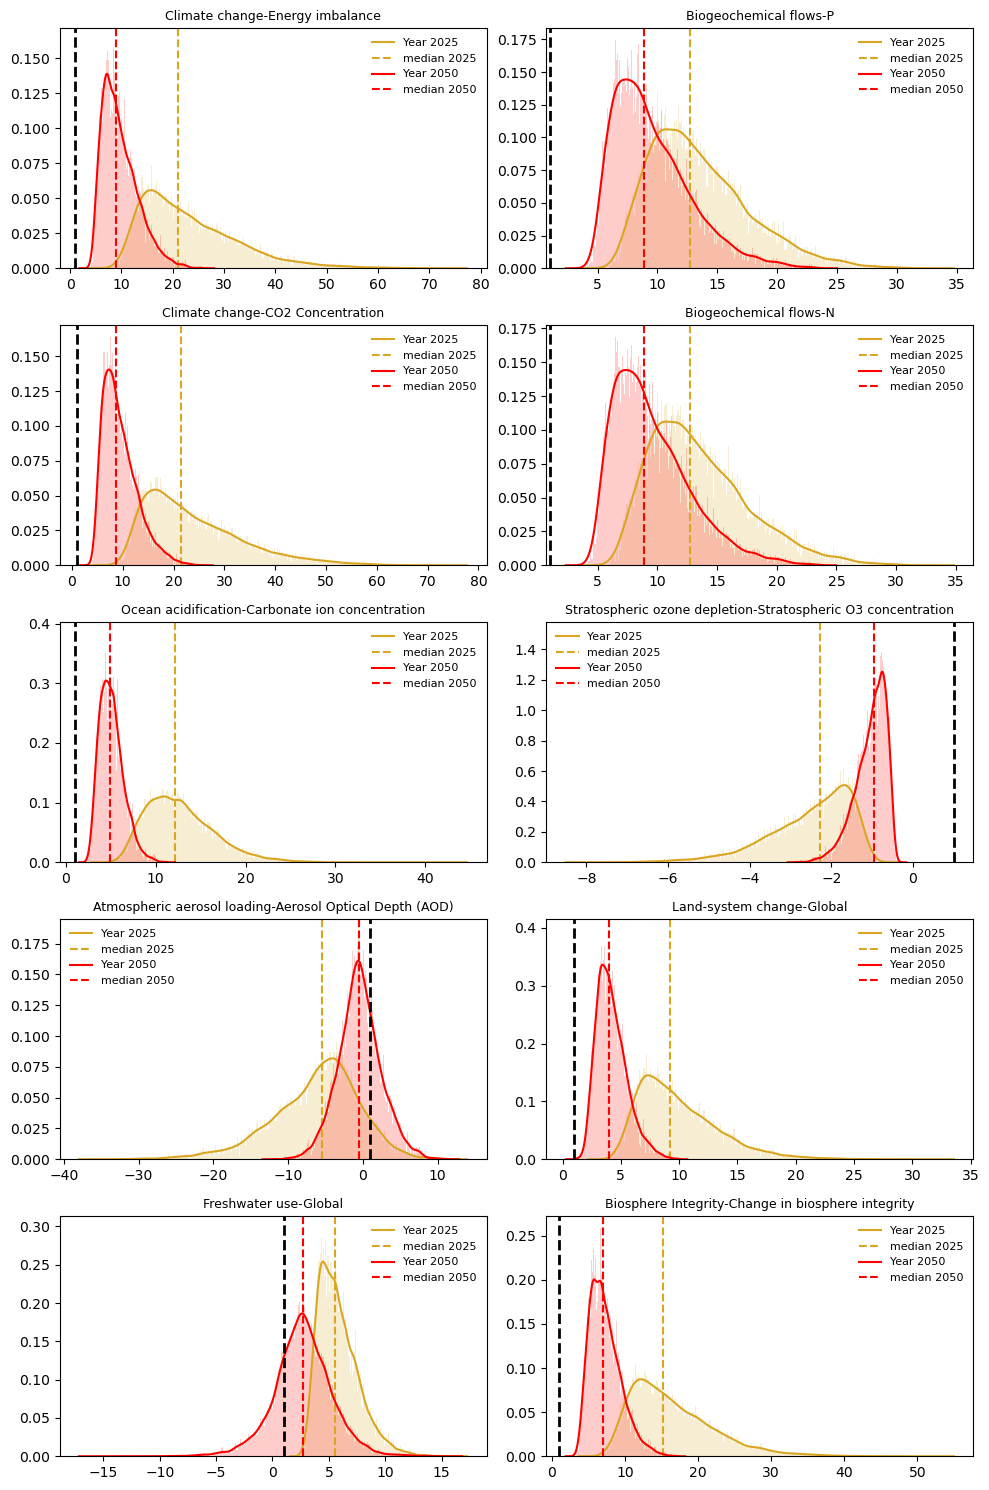

In [947]:
using KernelDensity

fig, axs = plt.subplots(5,2,figsize=(10,15))
for n in 1:2
    for y in 1:10
        colors=["goldenrod","red"]
        yrs=[2025,2050]
        axs[y].hist(x_res[y,:,n], bins=300,density=true, alpha=0.2, color=colors[n])
        kd = kde(x_res[y,:,n])
        axs[y].plot(kd.x, kd.density,label="Year $(yrs[n])",color=colors[n])
        axs[y].axvline(median(x_res[y,:,n]), linestyle="--", label="median $(yrs[n])",color=colors[n])
        axs[y].set_title(categories[y],fontsize=9)
        axs[y].legend(frameon=false, fontsize=8)
    end
end

for ax in axs
    ax.axvline(1, linestyle="--", label="Boundary",color="k",lw=2)
end

fig.tight_layout()
display(plt.gcf())
plt.close("all")


As we can see, with this small calculation, we won't be able to be within planetary boundaries. That's precisely why we used direct air capture of carbon dioxide to mitigate the impact on all boundaries. 


Let's now evalute costs

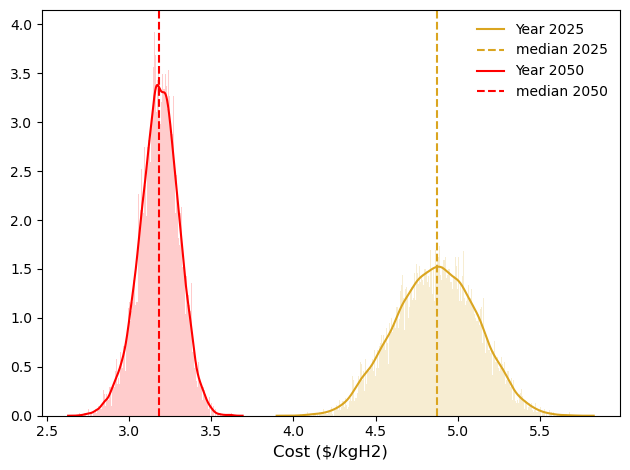

In [916]:
plt.figure()
for n in 1:2
    colors=["goldenrod","red"]
    yrs=[2025,2050]
    plt.hist(costs[:,n], bins=300,density=true, alpha=0.2,color=colors[n])
    p = kde(costs[:,n])
    plt.plot(p.x, p.density,label="Year $(yrs[n])",color=colors[n])
    plt.axvline(median(costs[:,n]), linestyle="--", label="median $(yrs[n])",color=colors[n])
end
plt.legend(frameon=false, fontsize=10)
plt.xlabel("Cost (\$/kgH2)",fontsize=12)
plt.tight_layout()
display(plt.gcf())
plt.close("all")


It is very low comared to the current cost of hydrogen production. It's important to remember that this is for demonstration only, we assumed/made up some costs. A more rigourous analysis might find much higher costs. 

Let's now look at how much electricity we use from each source (do not pay attention at the SSP1 tag. It's just copied from the excel sheet)

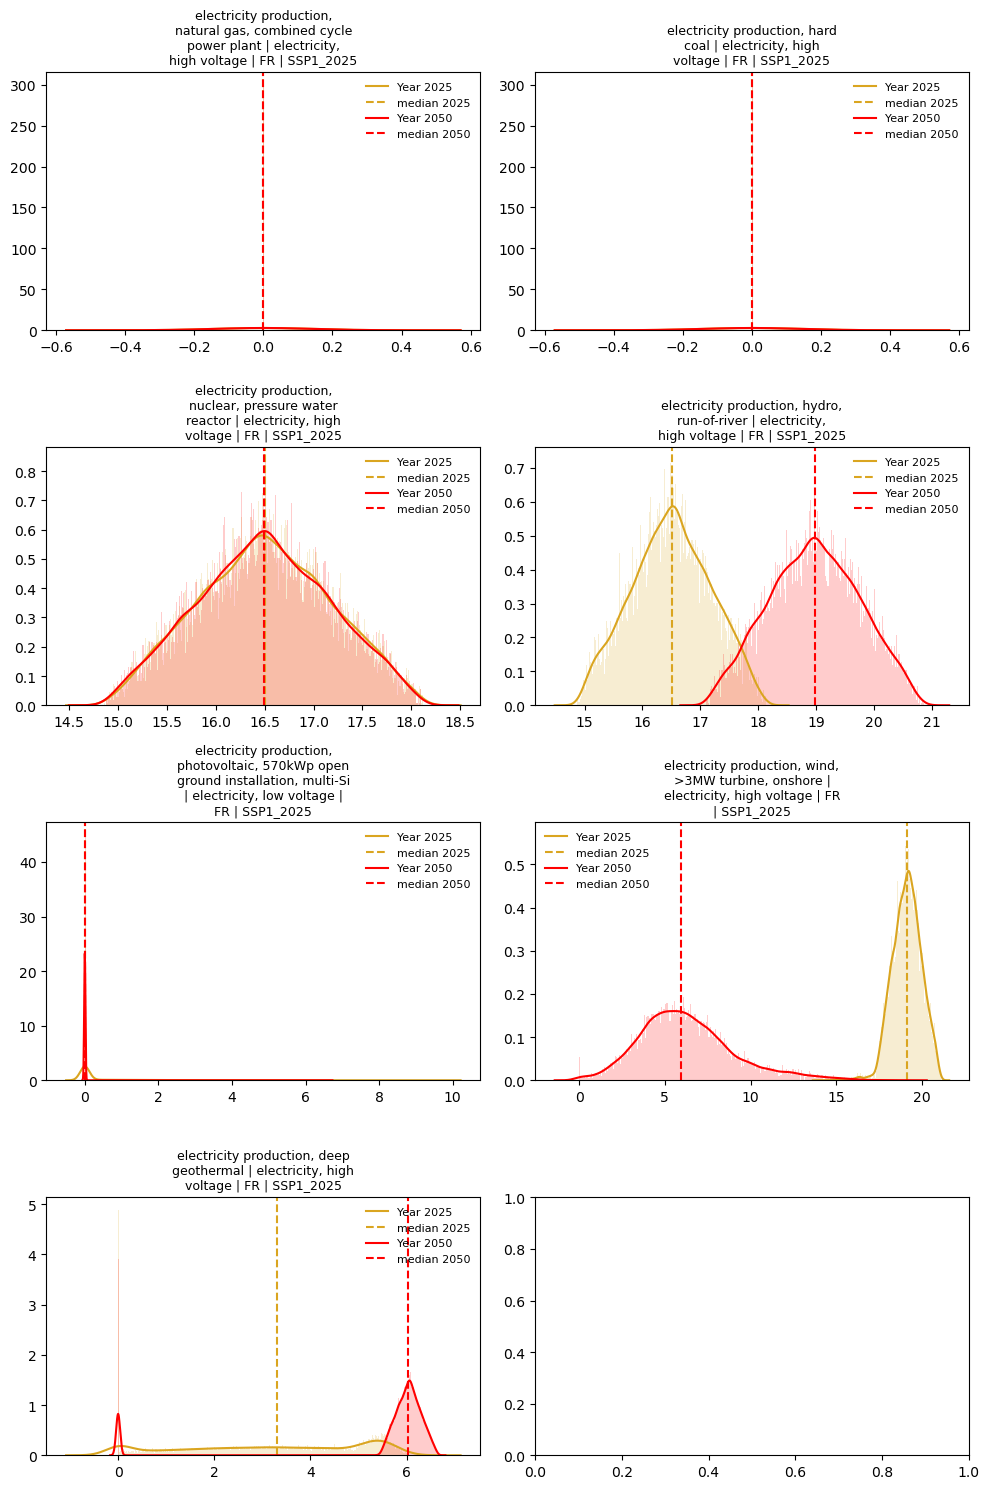

In [ ]:
electricity_labls=processes[electricity_set];
fig, axs = plt.subplots(4,2,figsize=(10,15))
for n in 1:2
    for y in 1:7
        colors=["goldenrod","red"]
        yrs=[2025,2050]
        axs[y].hist(s_res[y,:,n], bins=300,density=true, alpha=0.2, color=colors[n])
        kd = kde(s_res[y,:,n])
        axs[y].plot(kd.x, kd.density,label="Year $(yrs[n])", color=colors[n])
        axs[y].axvline(median(s_res[y,:,n]), linestyle="--", label="median $(yrs[n])", color=colors[n])
        axs[y].set_title(electricity_labls[y],fontsize=9)
        axs[y].legend(frameon=false, fontsize=8)
    end
end
fig.tight_layout()
display(plt.gcf())
plt.close("all")
